In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# Objective 
<p> Our objective is to train a time series forecasting model to anticipate demand ride_value in different parts of Tallinn.</p>
<p>
To do so, we need to make our dataset based on location and time for each day of the week. For the purposes of this task,  and considering that we have one month of data, we choose an hourly time frame for our predictions. 
</p>

<h2>Data</h2>
<p><b>start_date:</b>Time the order made</p>
<p><b>start_lat:</b>Latitude of start point</p>
<p><b>start_lng:</b>Langtitude of start point</p>
<p><b>end_lat:</b>Latitude of Destination point</p>
<p><b>end_lng:</b>Langtitude of Destination point</p>

In [2]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# Read the dataset
df = pd.read_csv('robotex4.csv')
# Month and year are all the same
df['day'] = pd.to_datetime(df['start_time']).dt.day
df['hour'] = pd.to_datetime(df['start_time']).dt.hour


<h1>Cleaning the data</h1>
<p>After analyzing input data, it is evident that there are some orders with extremly high ride_value which could bias our model. The first step is to detect and remove those outliers.</p>
<p>For this purpose, we use z-score on ride_value to determine the outliers in data. The formula of z-score is shown in image below.</p>
$$
zScore = \frac{x-\mu}{\sigma}
$$
<p>
Rows with a z-score of more than 3 will be removed. (z-score over 3 means that the value for that row varies from the mean by 3 times the Standard Deviation.)
</p>


In [4]:
# Calculate z-score of ride_value
df['zscore'] = (df['ride_value'] - df['ride_value'].mean())/df['ride_value'].std()
# Remove outliere which is 3x more than mean
df = df[df['zscore']<3]

<h1>Divide and conquer</h1>
<p>Our objective is to anticipate the location of high ride values in near future (in this task, the next hour). In order to reduce complexity and making decisioins based on location, the city will be divided into a NxN grid.</p>

In [5]:
# Divide locations into 4x4 grid
lat_n_grid = 4
lng_n_grid = 4
df['start_seg_lat'] = np.floor(((df['start_lat'] - df['start_lat'].min())/(df['start_lat'].max() - df['start_lat'].min())) * lat_n_grid)
df['start_seg_lng'] = np.floor(((df['start_lng'] - df['start_lng'].min())/(df['start_lng'].max() - df['start_lng'].min())) * lng_n_grid)

<i>The number of grids can be optimized by testing the order distribution, which is out of the scope of this task.</i>

<h1>Baseline Model</h1>
<p>To achieve our objective, we need a predictive model that can learn the historical patterns and identify recurring events. The LSTM model is chosen for this purpose. Since LSTM blocks keep the historical data in memory and can learn complex pattern, this model has both required properties that make it a good choice.</p> 

<h3><i>Hypothesis</i></h3>
<h4><i>LSTM model can be trained to effectively esimate the ride_value in a given location based on previous patterns</i></h4>

<p>To verify the hypothesis, we randomly choose a grid and use 80% of data for training and 20% of data to test.
Cell below shows the process of training and validating the model.</p>

In [19]:
ts2 = df[df['start_seg_lat'] == 1][df['start_seg_lng'] == 3].groupby(['day','hour'])['ride_value'].sum().values
X,y = split_sequence(ts,10)
X = X.reshape((X.shape[0], X.shape[1], 1))

x_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(X)*0.8)]

x_test = X[int(len(X)*0.8):]
y_test = y[int(len(X)*0.8):]
model = Sequential()
        
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
        
model.compile(optimizer='adam', loss='mse')
        
        
history = model.fit(x_test, y_test, epochs=200, verbose=0,validation_data=(x_test,y_test))
print("Validation Error: {}".format(history.history['val_loss'][-1]))

Validation Error: 23.393936157226562


<p>The architecture of model is presented in the cell below</p>

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


<h3>Learning curve</h3>
<p>As we can see in the figure below, our model has low variance and also low bias</p>

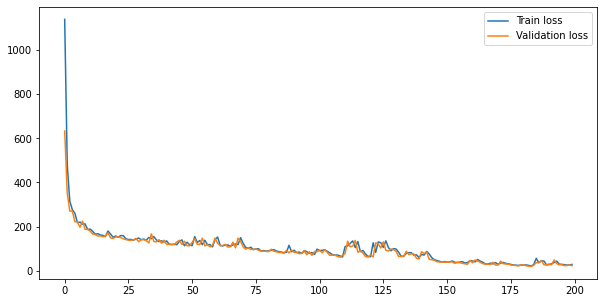

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()
plt.show()

<h3>Model prediction vs Ground truth</h3>

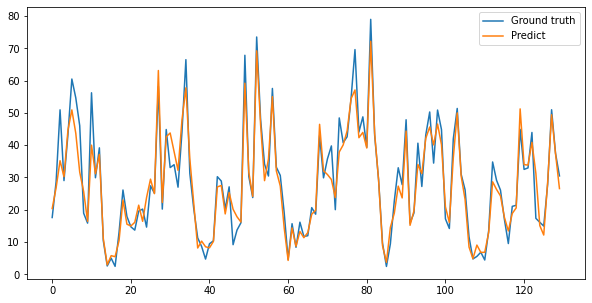

In [21]:
plt.figure(figsize=(10,5))
pred = model.predict(x_test)
plt.plot(y_test,label='Ground truth')
plt.plot(pred,label='Predict')
plt.legend()
plt.show()

<h1>Deploy the model</h1>
<p>To deploy the proposed model for anticipating ride_value, we need to train the model for each area and store the trained weight for later uses</p>
<p>As in the cell below, we've trained 16 models for each area in the 4x4 grid. For some grids we don't have any data, so those models will be None, and we can not infer any estimations for those grids.</p>

In [32]:
# Train a predictive model for each grid 
predictive_models = []
model_histories = []
for lat_grid in range(lat_n_grid):    
    for lng_grid in range(lng_n_grid):
        
        ts = df[df['start_seg_lat'] == lat_grid][df['start_seg_lng'] == lng_grid].groupby(['day','hour'])['ride_value'].sum().values
        X,y = split_sequence(ts,10)
        if len(X) == 0:
            predictive_models.append(None)
            model_histories.append(None)
            continue
        X = X.reshape((X.shape[0], X.shape[1], 1))
        model = Sequential()
        
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 1)))
        model.add(LSTM(50, activation='relu'))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mse')
        
        
        history = model.fit(X, y, epochs=200, verbose=0)
        model_histories.append(history)
        predictive_models.append(model)

# Model Loss

In [31]:
for region,history in enumerate(model_histories):
    if history:
        print("Loss value for region {} is: {}".format(region,history.history['loss'][-1]))

Loss value for region 0 is: 0.5489886999130249
Loss value for region 1 is: 32.720550537109375
Loss value for region 2 is: 0.8325293660163879
Loss value for region 3 is: 0.7785930037498474
Loss value for region 4 is: 25.397308349609375
Loss value for region 5 is: 3792.353759765625
Loss value for region 6 is: 5872.51318359375
Loss value for region 7 is: 0.7318180799484253
Loss value for region 8 is: 2.2349352836608887
Loss value for region 9 is: 29.410306930541992
Loss value for region 10 is: 334.6522521972656
Loss value for region 11 is: 266.5531005859375
Loss value for region 14 is: 0.8501008749008179
Loss value for region 15 is: 5.622203350067139


<h1>Last but not least</h1>
<p>So far, we have 16 predictive model for each area in Tallinn. These models can predict the next hour ride value of a specific area based on the latest 10 ride value.</p>
<h3>Use API web service</h3>
<p>
We can deploy this product as a web service which uses REST API to communicate. We can develop a Flask web server and provide one API to communicate with the model. The client sends the desireed location and the model will predict the next hours ride value and return the result.
</p>
<p>
A second API will be required to get the current hours order information(location,ride_value) and return the next hour ride value. We can use this to guide drivers towards the highest ride value in the next hour.
</p>
<p>
To keep the model up to date, we can use online learning algorithm. Every hour, we gather every order made and train all models with corresponding data.
</p>


<h1>Docker container</h1>
<p>
So far, we have our web service, which is able to communicate with client and return desire output. To deploy this web server, we can dockerize the web server application and run the docker on a specific port.
</p>


<h1>A-B Testing</h1>
<p>To perform A/B testing on our hypothesis, we should divide our drivers based on their performance. For example, we can categorize our drivers into high performance, mid performance and low performance driver</p>
<p>
To achieve a valid result with A/B test, we should choose between homogeneous drivers. We should choose N drivers from high performance category. Now we have to divide them into the two, Control and Treatment group.

</p>
<p>
The drivers in the treatment group are the one which we will suggest them the highest ride value area. Since we choose theese drivers from high performance category, we expect them use this information and go toward the suggested areas. 
   
</p>
<p>
 <b>Note:</b> The media that we are using to convey these information should be reliable.
</p>
<p>
Now we have a treatment group which are using our model to decide where to work. We should record both group performances each hour and suggest the treatment group new location for the next hour. 
</p>
<p>After some quality time, we analyze the performance of two groups to decide where our model does improve the performance or not?</p>
<p>To do so, To verfiy that we could achieve significant difference, we should calculate the p-value of two distribution.</p>

<p>
    <b>Note:</b>To choose N(number of drivers) with specifice margin of error and standard deviation we can use following equation
</p>
$$ 
sampleSize =\frac{zScore * std * (1-std)}{marginOfError^2} \\
$$
